In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# Model Building

At this point data consists of no apparent outlier and missing values. Qualitative features have been encoded appropriately. All features are in numerical format. Dataset is ready to train machine learning models.

In this notebook I train multiple machine learning models, fine-tune them and evaluate their performance using cross-validation. Root-Mean-Squared-Error (RMSE) between the logarithm of predicted and observed sale price is used as the evaluation metric for each validation set. Using logarithm of the sale price as the target variables ensures that the errors in predicting expensive and cheap houses will affect the results equally.

**Table of Contents** 
1. [Data Splitting](#Data-Splitting)
2. [Feature Standardization](#Feature-Standardization)
3. [Models](#Models)  
    3.1. [Linear Regression](#Linear-Regression)  
    3.2. [Ridge Regression](#Ridge-Regression)  
    3.3. [Lasso Regression](#Lasso-Regression)  
    3.4. [Elastic Net Regression](#Elastic-Net-Regression)  
    3.5. [Support Vector Machine Regression](#Support-Vector-Machine-Regression)  
    3.6. [Random Forest](#Random-Forest)    
    3.7. [Adaptive Boost](#Adaptive-Boost)    
    3.8. [Gradient Boost](#Gradient-Boost)    
4. [Model Performance](#Model-Performance)

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Import collection library
from collections import defaultdict

# Import visualization libraries
import matplotlib as mpl
import seaborn as sns
sns.set(style ='white',font_scale=1.25)
%matplotlib inline

# Set waring to 'ignore' to prevent them from prining on screen
import warnings
warnings.filterwarnings('ignore')

In [3]:
'''Import the processed dataset'''
with open('data/processed_data.pkl','rb') as file:
    train,y,test,FEATURES = pickle.load(file)
    
for feat in ['ExterQual','KitchenQual']:
    train[feat] = train[feat].astype(np.float)
    test[feat] = test[feat].astype(np.float)

## Data Splitting

Data is split in 70% training and 30% test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1017, 466)
X_test : (437, 466)
y_train : (1017,)
y_test : (437,)


## Feature Standardization

Standardize all features except those that are one hot encoded.

In [5]:
FEATURES.keys()

dict_keys(['cat', 'num', 'aug_num', 'eng_num', 'ord_num', 'onehot_cat', 'interactions', 'interactions_num'])

In [6]:
feat_to_norm = FEATURES['num'] + FEATURES['aug_num'] + FEATURES['eng_num'] + FEATURES['ord_num'] + FEATURES['interactions_num']
print('Total %i features to normalize' %(len(feat_to_norm)))

Total 246 features to normalize


In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)

print("X_train_preproc : " + str(X_train_preproc.shape))
print("X_test_preproc : " + str(X_test_preproc.shape))

X_train_preproc : (1017, 466)
X_test_preproc : (437, 466)


In [8]:
'''Initialize a named tuple that will store cross-validation mean and std of the model performance metric (RSME)'''

from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_train_rmse','cv5_std_train_rmse',
                              'cv5_mean_test_rmse','cv5_std_test_rmse'])
model_list = []

In [9]:
# Import linear regression model
from sklearn.linear_model import LinearRegression

# Import mean_squared_error and r2_score libraries
from sklearn.metrics import mean_squared_error, r2_score

# import cross validation score library
from sklearn.model_selection import cross_val_score

In [10]:
# Some functions that will be used frequently
def test_accuracy(y_test,y_pred):
    '''
    Takes y_test and y_pred and prints out R-sq, MSE, and RMSE
    '''
    print('Validation set performance measures:')
    print('-'*50)
    print('R-sq: %.3f' %(r2_score(y_test, y_pred)))
    print('MSE: %.3f' %(mean_squared_error(y_test, y_pred)))
    print('RMSE: %.3f' %(np.sqrt(mean_squared_error(y_test, y_pred))))

    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)
    print('-'*50)
    print('R-sq orig price: %.3f' %(r2_score(y_test_exp, y_pred_exp)))
    print('MSE orig price: %.2f' %(mean_squared_error(y_test_exp, y_pred_exp)))
    print('RMSE orig price: $%.2f' %(np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))))


def plot(model,model_name,X,X_val,y,y_val):
    
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(X_val)
    
    # Plot residuals
    plt.scatter(y_train_pred, y_train_pred - y, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test_pred - y_val, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    plt.show()

    # Plot predictions
    plt.scatter(y_train_pred, y, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_val, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Observed values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    
    
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

## Models
### Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)

y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

test_accuracy(y_test,y_test_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.441
MSE: 0.084
RMSE: 0.290
--------------------------------------------------
R-sq orig price: -6.528
MSE orig price: 40078972846.05
RMSE orig price: $200197.33


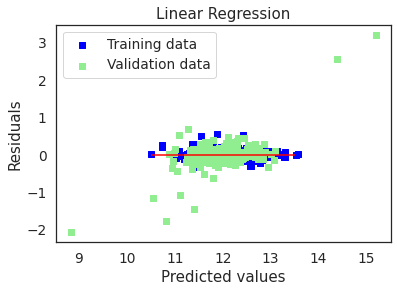

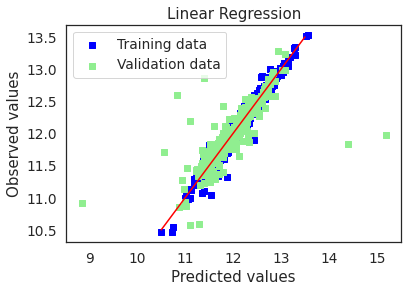

In [12]:
plot(lr,"Linear Regression",X_train_preproc,X_test_preproc,y_train,y_test)

In [13]:
cv5_train_rmse =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.20598253 0.20961447 0.70670994 7.79822149 0.26921657]
---------------------------------------------------------------------------
cv5 test rmse: [0.76827203 1.138192   0.81778919 1.28980219 0.75990774]


### Ridge Regression

In [14]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 30.0


In [15]:
ridge = Ridge(alpha=30)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

test_accuracy(y_test,y_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.909
MSE: 0.014
RMSE: 0.117
--------------------------------------------------
R-sq orig price: 0.910
MSE orig price: 478516927.37
RMSE orig price: $21875.03


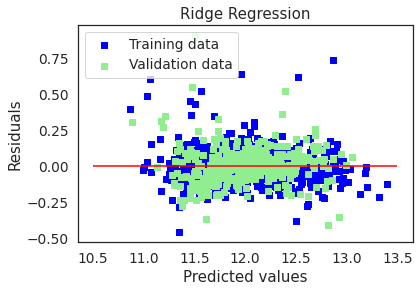

Ridge picked 454 features and eliminated the other 12 features


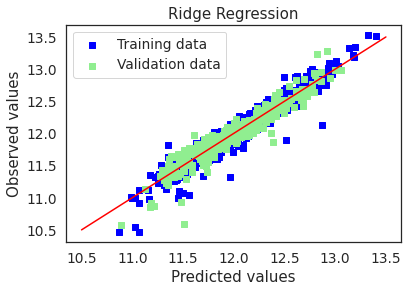

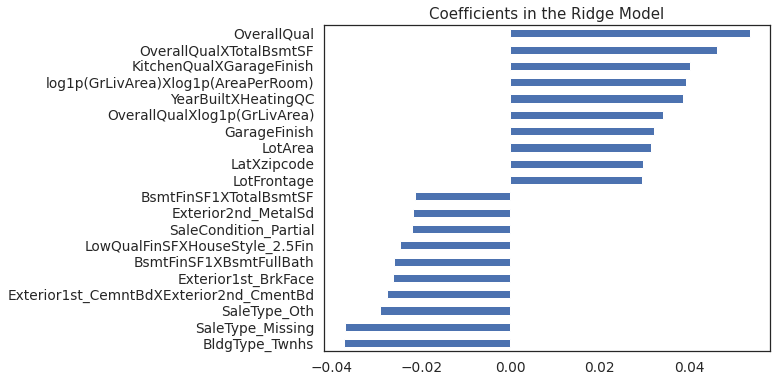

In [16]:
# Plot residuals and predicted value plots
plot(ridge,"Ridge Regression",X_train_preproc,X_test_preproc,y_train,y_test)

# Plot important coefficients
plt.figure()
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [17]:
cv5_train_rmse =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13729775 0.15145262 0.11535025 0.12181316 0.10309681]
---------------------------------------------------------------------------
cv5 test rmse: [0.12090563 0.12652353 0.14737171 0.10683139 0.10270972]


### Lasso Regression

In [18]:
from sklearn.linear_model import LassoCV, Lasso

In [19]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_preproc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0003


In [20]:
lasso = Lasso(alpha=0.0003)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)

test_accuracy(y_test,y_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.901
MSE: 0.015
RMSE: 0.122
--------------------------------------------------
R-sq orig price: 0.897
MSE orig price: 548510733.55
RMSE orig price: $23420.31


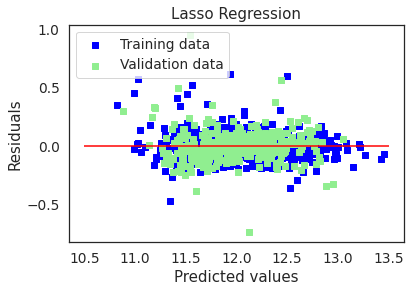

Lasso picked 174 features and eliminated the other 292 features


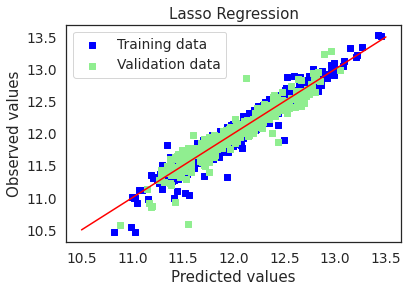

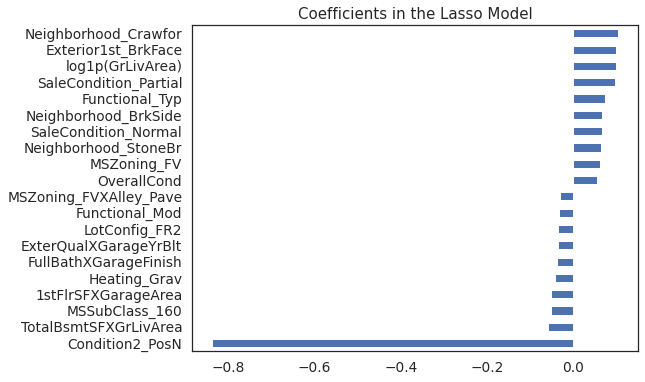

In [21]:
# Plot residuals and predicted value plots
plot(lasso,"Lasso Regression",X_train_preproc,X_test_preproc,y_train,y_test)

# Plot important coefficients
plt.figure()
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [22]:
cv5_train_rmse =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13966214 0.14872952 0.11481515 0.11832687 0.1029308 ]
---------------------------------------------------------------------------
cv5 test rmse: [0.12335639 0.13357488 0.15226293 0.10698545 0.10213062]


### Elastic Net Regression

In [23]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [24]:
enet = ElasticNetCV(l1_ratio=np.arange(0,1.1,0.1),
             alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
             cv=5,
             max_iter=50000,
             n_jobs=16,
             random_state=42)
enet.fit(X_train_preproc, y_train)

print('Best alpha: ',enet.alpha_)
print('Best l1_ratio: ',enet.l1_ratio_)

Best alpha:  0.0006
Best l1_ratio:  0.9


In [25]:
enet = ElasticNet(l1_ratio=0.9,alpha=0.0006)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

test_accuracy(y_test,y_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.909
MSE: 0.014
RMSE: 0.117
--------------------------------------------------
R-sq orig price: 0.909
MSE orig price: 485921339.83
RMSE orig price: $22043.62


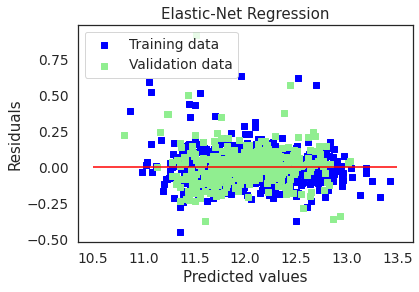

Elastic-Net picked 146 features and eliminated the other 320 features


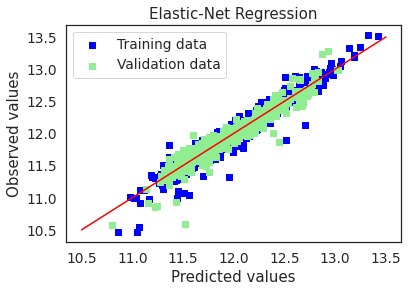

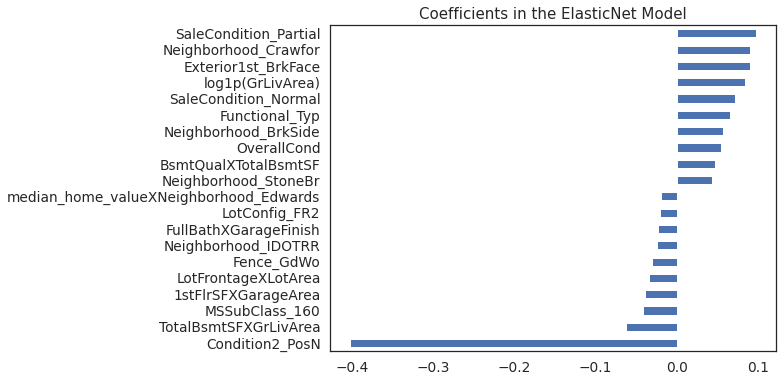

In [26]:
# Plot residuals and predicted value plots
plot(enet,"Elastic-Net Regression",X_train_preproc,X_test_preproc,y_train,y_test)

# Plot important coefficients
plt.figure()
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("Elastic-Net picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [27]:
cv5_train_rmse =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='enet',params=enet.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13852348 0.15183482 0.11231201 0.12001222 0.10056093]
---------------------------------------------------------------------------
cv5 test rmse: [0.12009171 0.12695604 0.14997704 0.10703355 0.09994046]


### Support Vector Machine Regression

In [28]:
from sklearn.svm import SVR

In [29]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='scale', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

test_accuracy(y_test,y_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.896
MSE: 0.016
RMSE: 0.125
--------------------------------------------------
R-sq orig price: 0.907
MSE orig price: 493854773.69
RMSE orig price: $22222.84


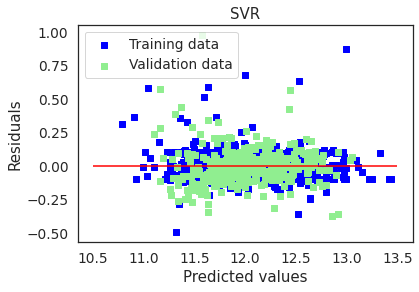

SVR picked up 432 features and eliminated 34 features


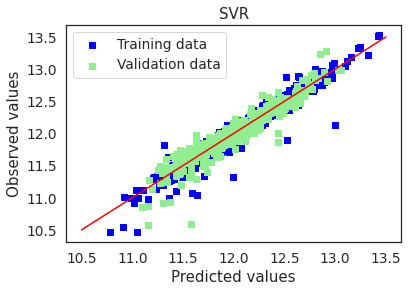

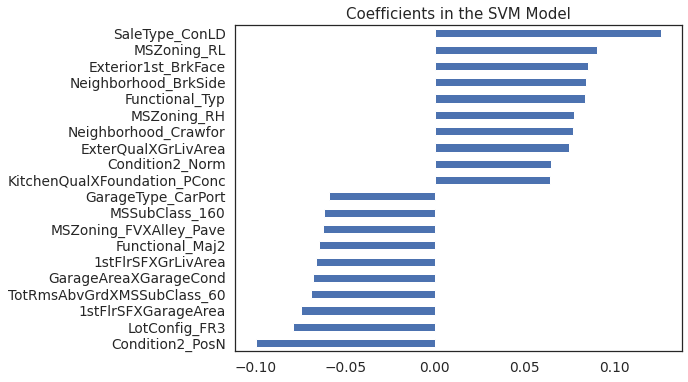

In [30]:
# Plot residuals and predicted value plots
plot(svm,"SVR",X_train_preproc,X_test_preproc,y_train,y_test)

# Plot important coefficients
plt.figure()
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [31]:
cv5_train_rmse =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.14957504 0.16388119 0.12907443 0.12985662 0.12969331]
---------------------------------------------------------------------------
cv5 test rmse: [0.13748197 0.14273305 0.14976952 0.13041601 0.11279205]


### Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [33]:
param_dist = dict(n_estimators=[200,500,700,900,1200],max_features=["auto","sqrt",'log2'])
rf_cv = RandomizedSearchCV(RandomForestRegressor(),
                           param_distributions=param_dist,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_iter=10)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_estimator_)

RandomForestRegressor(max_features='sqrt', n_estimators=500)


In [34]:
rf = RandomForestRegressor(max_features='sqrt', n_estimators=500)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

test_accuracy(y_test,y_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.888
MSE: 0.017
RMSE: 0.130
--------------------------------------------------
R-sq orig price: 0.904
MSE orig price: 509606825.67
RMSE orig price: $22574.47


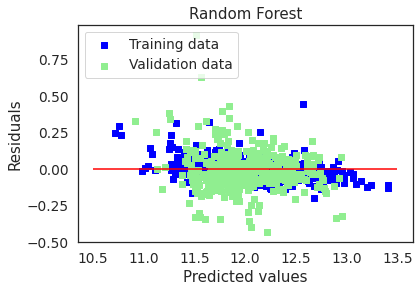

Text(0.5, 1.0, 'Top 10 Important Features')

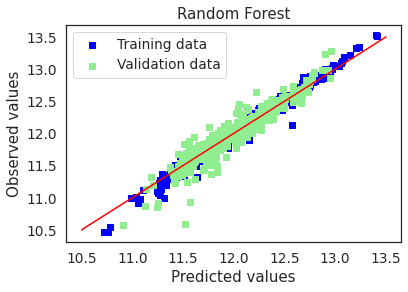

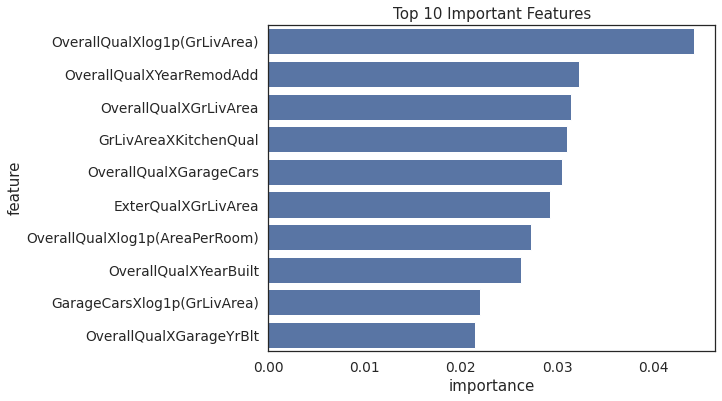

In [35]:
# Plot residuals and predicted value plots
plot(rf,"Random Forest",X_train,X_test,y_train,y_test)

# Plot feature importance
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [36]:
cv5_train_rmse =  cv_rmse(rf, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(rf, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15856904 0.14891844 0.14843402 0.1541274  0.1178545 ]
---------------------------------------------------------------------------
cv5 test rmse: [0.13446462 0.14056835 0.17413614 0.10476667 0.12548509]


### Adaptive Boost

In [37]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)
print(ada_cv.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=None,
                                                       max_depth=25,
                                                       min_samples_leaf=12,
                                                       min_samples_split=15,
                                                       presort=False),
                  learning_rate=0.5, loss='square', n_estimators=400)


In [38]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                             max_depth=25,
                                                             min_samples_leaf=12,
                                                             min_samples_split=15,
                                                             presort=False),
                  learning_rate=0.5, loss='square', n_estimators=400)
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)

test_accuracy(y_test,y_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.892
MSE: 0.016
RMSE: 0.128
--------------------------------------------------
R-sq orig price: 0.913
MSE orig price: 464898452.74
RMSE orig price: $21561.50


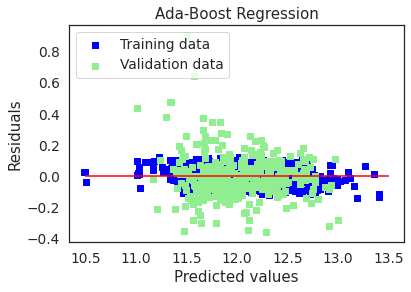

Text(0.5, 1.0, 'Top 10 Important Features')

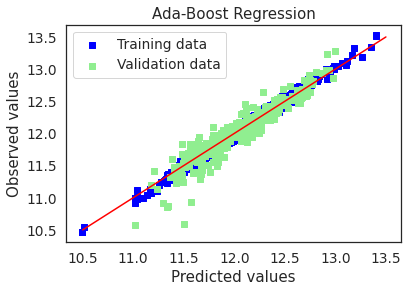

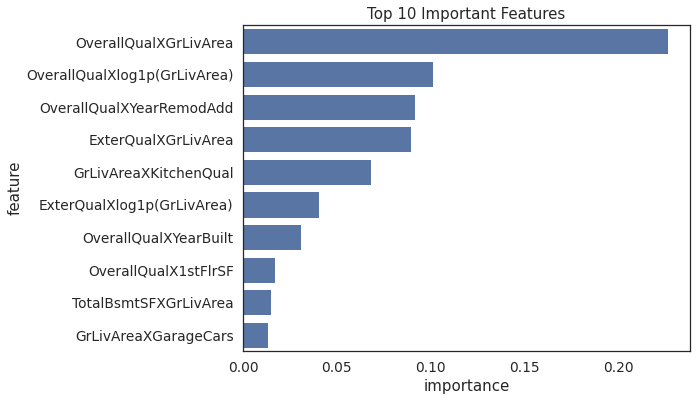

In [39]:
# Plot residuals and predicted value plots
plot(ada,"Ada-Boost Regression",X_train,X_test,y_train,y_test)

# Plot feature importance
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [40]:
cv5_train_rmse =  cv_rmse(ada, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ada, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15186468 0.14950936 0.14264553 0.15061059 0.13358766]
---------------------------------------------------------------------------
cv5 test rmse: [0.13857427 0.14940531 0.17829601 0.09666731 0.11867193]


### Gradient Boost

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

In [42]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_test)

test_accuracy(y_test,y_pred)

Validation set performance measures:
--------------------------------------------------
R-sq: 0.910
MSE: 0.014
RMSE: 0.117
--------------------------------------------------
R-sq orig price: 0.912
MSE orig price: 469627972.75
RMSE orig price: $21670.90


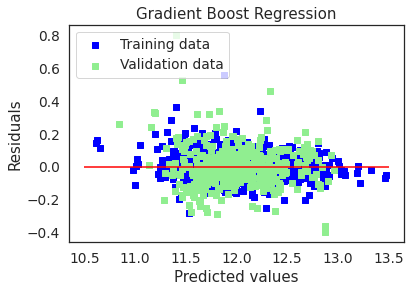

Text(0.5, 1.0, 'Top 10 Important Features')

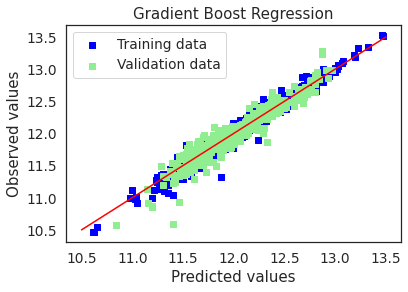

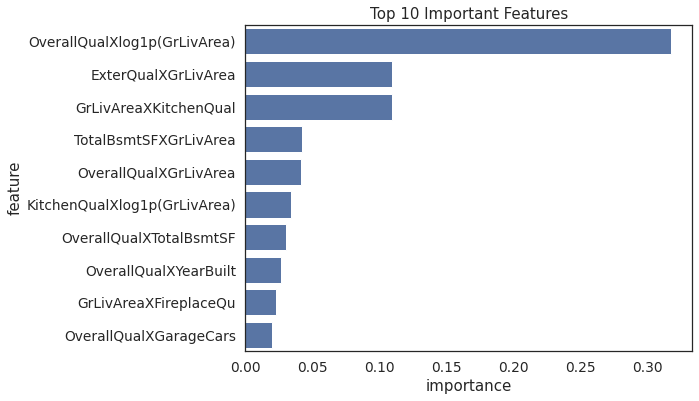

In [43]:
# Plot residuals and predicted value plots
plot(gbrt,"Gradient Boost Regression",X_train,X_test,y_train,y_test)

# Plot feature importance
feature_importance = pd.DataFrame(np.round(gbrt.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [44]:
cv5_train_rmse =  cv_rmse(gbrt, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(gbrt, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='gbrt',params=gbrt.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15023405 0.14097682 0.13690015 0.14392226 0.12119624]
---------------------------------------------------------------------------
cv5 test rmse: [0.12201976 0.15387113 0.17007066 0.10676152 0.11440573]


## Model Performance

In [45]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_train_rmse,
                           model.cv5_std_train_rmse,
                           model.cv5_mean_test_rmse,
                           model.cv5_std_test_rmse],
                          index=['model',
                                   'train_mean_rmse',
                                   'train_std_rmse',
                                   'test_mean_rmse',
                                   'test_std_rmse']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [46]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [47]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            8 non-null      object 
 1   train_mean_rmse  8 non-null      float64
 2   train_std_rmse   8 non-null      float64
 3   test_mean_rmse   8 non-null      float64
 4   test_std_rmse    8 non-null      float64
dtypes: float64(4), object(1)
memory usage: 448.0+ bytes


Text(0.5, 1.0, 'Train vs. Validation RMSE')

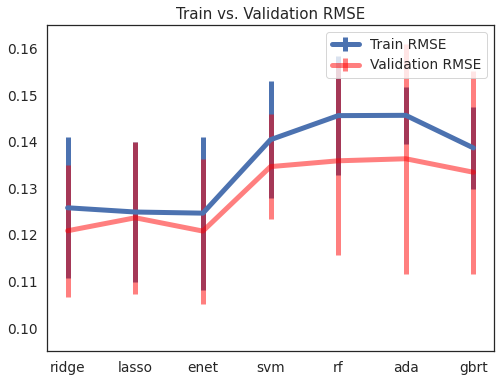

In [48]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_rmse']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_rmse'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_rmse']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_rmse'],
             yerr=test_errorbar_width_array,
             label='Validation RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.ylim(0.095,0.165)
plt.title('Train vs. Validation RMSE')

In [49]:
mod_table.rename(columns={'test_mean_rmse':'val_mean_rmse','test_std_rmse':'val_std_rmse'},inplace=True)

In [50]:
mod_table.sort_values(by=['val_mean_rmse','val_std_rmse'],ascending=[True,True])

,model,train_mean_rmse,train_std_rmse,val_mean_rmse,val_std_rmse
3,enet,0.124649,0.018360,0.120800,0.017403
1,ridge,0.125802,0.016916,0.120868,0.015882
2,lasso,0.124893,0.016813,0.123662,0.018210
7,gbrt,0.138646,0.009748,0.133426,0.024346
4,svm,0.140416,0.014068,0.134639,0.012631
5,rf,0.145581,0.014351,0.135884,0.022643
6,ada,0.145644,0.006821,0.136323,0.027648
0,LR,1.837949,2.985976,0.954793,0.217902


Train and validation RMSE values of the __Lasso Regression__ model are very similar and reasonably low. Lasso regression performed the best on test dataset provided by kaggle. The test RMSE was 0.11840 which placed the submission in the top 5% of kaggle's leaderboard.